In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('../input/data-spam/spam_email.txt',sep=' ')
sp_data=data.loc[:,'make':'cap_total']
sp_data.describe(include='all')

,make,address,all,3d,our,over,remove,internet,order,mail,...,conference,semicol,paren,bracket,bang,dollar,pound,cap_avg,cap_long,cap_total
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,10.000000,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X=sp_data.values
yCh=data.values[:,57]
y=np.zeros((yCh.size))
y[yCh=='ham']=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

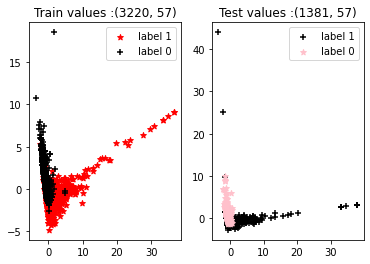

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca= PCA(n_components=2)
fig, (plt_train, plt_test) = plt.subplots(1, 2)
data1=pca.fit_transform(X_train_scaled)
h1=data1[(y_train==1)]
h2=data1[(y_train==0)]
plt_train.set_title('Train values :'+ str(X_train_scaled.shape))
plt_train.scatter(h1[:,0],h1[:,1],marker='*',c="red")
plt_train.scatter(h2[:,0],h2[:,1],marker='+',c="black")
plt_train.legend(['label 1','label 0'])
data2=pca.fit_transform(X_test_scaled)
g1=data2[(y_test==1)]
g2=data2[(y_test==0)]
plt_test.set_title('Test values :'+str(X_test_scaled.shape))
plt_test.scatter(g1[:,0],g1[:,1],marker='+',c="black")
plt_test.scatter(g2[:,0],g2[:,1],marker='*',c="pink")
plt_test.legend(['label 1','label 0'])

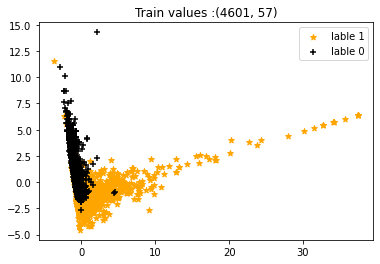

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca= PCA(n_components=2)

X_scaled = std_scaler.transform(X)
datax=pca.fit_transform(X_scaled)
x1=datax[(y==1)]
x2=datax[(y==0)]
plt.title('Train values :'+ str(X.shape))
plt.scatter(x1[:,0],x1[:,1],marker='*',c="orange")
plt.scatter(x2[:,0],x2[:,1],marker='+',c="black")
plt.legend(['lable 1','lable 0'])

In [5]:
class RatingModel:
    def __init__(self, y_1, y_2):
      self.y_1=y_1
      self.y_2=y_2
      self.TN=np.size(y_2[(y_2==-1)&(y_1==y_2)])
      self.FN=np.size(y_2[(y_2==-1)&(y_1!=y_2)])
      self.TP=np.size(y_2[(y_2==1)&(y_1==y_2)])
      self.FP=np.size(y_2[(y_2==1)&(y_1!=y_2)])
      self.y_1[self.y_1==0]=-1
      self.y_2[self.y_2==0]=-1
     
    def _rep():
        return ""
    def accur_Error(self, y_1, y_2):
        rs=(self.TP+self.TN)/(y_1.size)
        return [rs,(1-rs)]
    def sensitivity(self):
        P=np.size(self.y_1[self.y_1==1])
        return (self.TP)/(P)
    def specificity(self):
        N=np.size(self.y_1[self.y_1==-1])
        return (self.TN)/(N)
    def precision(self):
        rs=self.TP+self.FP
        return (self.TP)/(rs)
    def recall(self):
        rs=self.TP+self.FN
        return (self.TP)/(rs)
    def rating(self):
        return [self.accur_Error(self.y_1, self.y_2), self.sensitivity(), self.specificity(), self.precision(), self.recall()]
class DecisionStump:
    def __init__(self, T=100): #
        self.T = T
        pass

    def fit(self, X: np.ndarray, y: np.ndarray, sample_weight: np.ndarray):
        T = self.T
        W=sample_weight
        nrow, ncol = X.shape
        assert nrow == y.size

        bestn = 0
        bestd = 1
        bestp = 0
        minerr = W.sum()
        for i in range(ncol):
            err, d, p = self._optimize(X[:, i], y, W, T)
            if err < minerr:
                minerr = err
                bestn = i
                bestd = d
                bestp = p
        
        self.features = ncol
        self.bestn = bestn
        self.bestd = bestd
        self.bestp = bestp

        return self

    def _optimize(self, X, y, W, T):
        X = X.flatten()
        min_x, max_x = X.min(), X.max()
        len_x = max_x - min_x
        
        bestd = 1
        bestp = min_x
        minerr = W.sum()

        if len_x > 0.0:
            for p in np.arange(min_x, max_x, len_x/T):
                for d in [-1, 1]:
                    gy = np.ones((y.size))
                    gy[X*d < p*d] = -1
                    err = np.sum((gy != y)*W)
                    if err < minerr:
                        minerr = err
                        bestd = d
                        bestp = p

        return minerr, bestd, bestp

    def predict(self, test_set : np.ndarray):
        nrow, ncol = test_set.shape

        assert ncol == self.features

        icol = test_set[:, self.bestn]
        h = np.ones((nrow))
        h[icol*self.bestd < self.bestp*self.bestd] = -1
        return h
class AdaBoost:
    def __init__(self , T, hmodel = DecisionStump()):
        self.T=T
        self.hmodel=hmodel
    def fit(self, X: np.ndarray, y_1: np.ndarray, verbose=False):
      n = X.shape[0]
      T = self.T
      y=y_1
      y[y==0]=-1
    # init numpy arrays
      self.D = np.zeros(shape=(T, n))
      self.h = np.zeros(shape=T, dtype=object)
      self.alpha = np.zeros(shape=T)
      self.errors = np.zeros(shape=T)
      self.ratting = np.zeros(shape=(T,2))

      # initialize weights uniformly
      self.D[0] = np.ones(shape=n) / n

      for t in range(T):
          # fit  weak learner
          D_ = self.D[t]
          h_ = DecisionStump(40)
          h_ = h_.fit(X, y, D_)

          # calculate error and stump weight from weak learner prediction
          Pr_ = h_.predict(X)
          error_ = D_[(Pr_ != y)].sum()# / n
          alpha_ = np.log((1 - error_) / error_) / 2

          # update sample weights
          D_new = (
              D_ * np.exp(-alpha_ * y * Pr_)
          )
          
          D_new /= D_new.sum()

          # If not final iteration, update sample weights for t+1
          if t+1 < T:
              self.D[t+1] = D_new

          # save results of iteration
          self.h[t] = h_
          self.alpha[t] = alpha_
          self.errors[t] = error_
          # ae=np.array([0,0])
          if t>0:
            Pr_temp=self.predictmodul(X,t)
            modelra=RatingModel(y, Pr_temp)
            self.ratting[t,:]=modelra.accur_Error(y, Pr_temp)
          if verbose: print('Time {0}-th weak: accuracy={1}, error={2}'.format (t, self.ratting[t,0], self.ratting[t,1]))
      return self
    def predict(self, X):
        Pr_ = np.array([h_.predict(X) for h_ in self.h])
        return np.sign(np.dot(self.alpha, Pr_))
    def predictmodul(self, X, i):
        h_temp=self.h[:i]
        alpha_temp=self.alpha[:i]
        Pr_ = np.array([h_.predict(X) for h_ in h_temp])
        return np.sign(np.dot(alpha_temp, Pr_))

In [6]:
model=AdaBoost(40)
model=model.fit(X_train_scaled, y_train,  True )
Pr=model.predict( X_test_scaled)
Pr[(Pr==0)]=-1
print(Pr, y_test)

Time 0-th weak: accuracy=0.0, error=0.0
Time 1-th weak: accuracy=0.7832298136645963, error=0.21677018633540368
Time 2-th weak: accuracy=0.7832298136645963, error=0.21677018633540368
Time 3-th weak: accuracy=0.8487577639751552, error=0.15124223602484477
Time 4-th weak: accuracy=0.8220496894409938, error=0.17795031055900623
Time 5-th weak: accuracy=0.868944099378882, error=0.13105590062111805
Time 6-th weak: accuracy=0.8779503105590062, error=0.12204968944099381
Time 7-th weak: accuracy=0.8804347826086957, error=0.11956521739130432
Time 8-th weak: accuracy=0.884472049689441, error=0.11552795031055896
Time 9-th weak: accuracy=0.8804347826086957, error=0.11956521739130432
Time 10-th weak: accuracy=0.8888198757763975, error=0.11118012422360246
Time 11-th weak: accuracy=0.8838509316770187, error=0.11614906832298133
Time 12-th weak: accuracy=0.8913043478260869, error=0.10869565217391308
Time 13-th weak: accuracy=0.8869565217391304, error=0.11304347826086958
Time 14-th weak: accuracy=0.8922360

Text(0, 0.5, 'Mất / Chính xác')

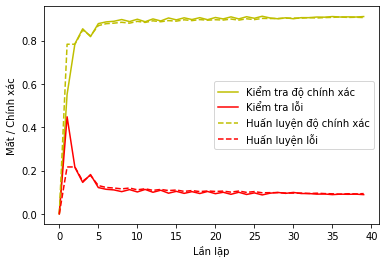

In [7]:
ra_Xtest = np.zeros(shape=(model.T,2))
for i in range(1,model.T):
  Pr_i=model.predictmodul(X_test_scaled,i)
  modelra=RatingModel(y_test, Pr_i)
  ra_Xtest[i,:]=modelra.accur_Error(y_test, Pr_i)
ra_Xtrain = np.zeros(shape=(model.T,2))
for i in range(1,model.T):
  Pr_i=model.predictmodul(X_train_scaled,i)
  modelra=RatingModel(y_train, Pr_i)
  ra_Xtrain[i,:]=modelra.accur_Error(y_train, Pr_i)
iter=range(model.T)
plt.plot(iter,ra_Xtest[:,0],'y-', label='Kiểm tra độ chính xác')
plt.plot(iter,ra_Xtest[:,1],'r-', label='Kiểm tra lỗi')
plt.plot(iter,ra_Xtrain[:,0],'y--', label='Huấn luyện độ chính xác')
plt.plot(iter,ra_Xtrain[:,1],'r--', label='Huấn luyện lỗi')
plt.legend(loc='center right')
plt.xlabel('Lần lặp')
plt.ylabel('Mất / Chính xác')

128 (1381,)


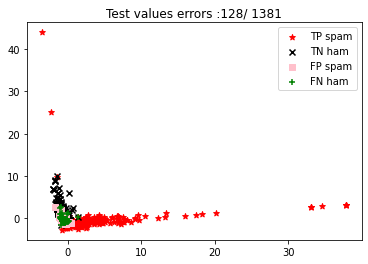

In [8]:
sumerror=0;
y_new=y_test
y_new[y_new==0]=-1
for i in range(y_new.shape[0]):
  if y_new[i]!=Pr[i]: 
    sumerror+=1
print(sumerror, y_new.shape)
gT1=data2[(Pr==1)]
gT0=data2[(Pr==-1)]
gF1=data2[(y_new!=Pr)&(Pr==1)]
gF0=data2[(y_new!=Pr)&(Pr==-1)]
plt.title('Test values errors :'+str(sumerror)+'/ '+str(X_test_scaled.shape[0]))

plt.scatter(gT1[:,0],gT1[:,1], marker='*', c='red')
plt.scatter(gT0[:,0],gT0[:,1], marker='x', c='black')
plt.scatter(gF1[:,0],gF1[:,1], marker='s', c='pink')
plt.scatter(gF0[:,0],gF0[:,1], marker='+',c='green')
plt.legend(['TP spam','TN ham','FP spam','FN ham'])